# Sentiment Analysis

### ECE590 Homework assignment 2
Name: Javier Cervantes
net id: jc1010

We are interested in sentiment analysis. Given a short document, we wish to assess whether the corresponding sentiment is positive (label 𝑦=1 ) or negative (label 𝑦=0). The assignment is as follows: 

1. For every word, we will learn a corresponding d-dimensional vector $x_i \in \mathbb{R}^d$ for word $i$ in the vocabulary. 

2. Assume that there are $M_j$ words in document $j$. The feature vector for this document is $f_j = \frac{1}{M_j} \sum_{i=1}^{M_j} x_{(m, j)}$ such that $x_{(m, j)}$ is the d-dimensional vector for the m-th word in document j.

3. The probability of positive sentiment for document j is modeled as $P(y_j = 1 | f_j) = \sigma[w \cdot f_j + b]$ where $\sigma$ is the sigmoid function, $w \in \mathbb{R}^d$ is the weight vector and $b \in \mathbb{R}$ is the bias.

In [74]:
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import nltk
from nltk.corpus import stopwords
from datasets import load_from_disk
import numpy as np
import tqdm
import pandas as pd
from datasets import Dataset
import collections
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
seed = 257

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Prepare the data

We begin by tokenizing and cleaning the text. In this process, we'll remove punctuation, convert to lowercase, and remove stopwords. I believe that it's worth noting that removing stop words might be problematic in some model designs. For this particular model, which doesn't take into account word order, removing words like "not" should not affect the model's performance because the model won't have the capability of identifying where upon a given document the word "not" is located.

In [3]:
# load the dataset
train_data, test_data = load_dataset("yelp_polarity", split=["train", "test"])

In [4]:
# tokenize the dataset
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")


def tokenize(obs, tokenizer, max_length):
    """
    Tokenize an observation
    max_length: the maximum length of the tokenized sequence
    """
    return {"tokens": tokenizer(obs["text"])[:max_length]}

In [6]:
# remove stopwords and punctuation
stop_words = stopwords.words("english")


def remove_stopwords(obs):
    """
    Removes stopwords from tokens for each obs in Dataset
    """
    obs["tokens"] = [word for word in obs["tokens"] if word not in stop_words]
    return obs


def remove_punctuation(obs):
    """
    Removes punctuation from tokens for each obs in Dataset
    """
    obs["tokens"] = [word for word in obs["tokens"] if word.isalpha()]
    return obs


def tokenize_and_clean(obs, max_length):
    """
    Tokenize, remove stopwords and punctuation from observation
    """
    tokens = tokenizer(obs["text"][:max_length])
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word.isalpha()]
    return {"tokens": tokens}


# train_data = train_data.map(remove_stopwords)

Working under the assumption that a document's sentiment can be identified rather quickly, I've set the maximum length of a document to 100 words. This is a hyperparameter that can be adjusted to improve the model's performance.

In [60]:
max_length = 100

train_data = train_data.map(tokenize_and_clean, fn_kwargs={"max_length": max_length})
test_data = test_data.map(tokenize_and_clean, fn_kwargs={"max_length": max_length})

Map:   0%|          | 0/38000 [00:00<?, ? examples/s]

Now that our data has been tokenized and cleaned, we can create a validation set.

In [9]:
# validation data
train_valid_data = train_data.train_test_split(test_size=0.25)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

From the training data, we now proceed to create a vocabulary comprised of the training data's unique words. Given the large number of documents in the training set, I'll add a minimum frequency threshold of 30 for every word to be included in the vocabulary. Given the large number of observations we have available, removing words that appear only a few times should not affect the model's performance.

Also very important in the creation of our vocabulary is to add a couple of special tokens: one for padding and one for unknown words. The padding token will be used to make all documents the same length, and the unknown token will be used to catch words that are not in the vocabulary.

In [10]:
# creating the vocabulary
special_tokens = ["<unk>", "<pad>"]

# setting a minimum frequency for the tokens ... 30 times in 420,000 sentences is not a lot
vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"], specials=special_tokens, min_freq=30
)
vocab.set_default_index(vocab["<unk>"])
len(vocab)

7827

We now have a vocabulary of 7,827 unique words (including the special tokens). The Vocab object has a method that is used to identify unknown words and replace them with the unknown token. We utilize that method to assign the index of "unk".

Now that we have the vocabulary, we can numerically encode the words in the data using indices from the vocabulary we just created. We also need to pad the sequences so that they're all the same length and we don't run into issues when inputting them into the model.

In [61]:
def numericalize_example(obs, vocab):
    ids = vocab.lookup_indices(obs["tokens"])
    return {"ids": ids}


train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [62]:
train_data = train_data.with_format("torch", columns=["ids", "label"])
valid_data = valid_data.with_format("torch", columns=["ids", "label"])
test_data = test_data.with_format("torch", columns=["ids", "label"])

We're going to make use of data loaders. This will allow us to load the data in batches, which will be useful for training the model. This is where we'll use the padding process mentioned above. In this process we need to adequately structure the data so that it can be input into the model. We'll make use of a collate function to do this. Since we're working with PyTorch, we'll create a single tensor for each batch of data and a single tensor for the labels. Note that the data tensor will have a shape of (batch_size, max_length) and the labels tensor will have a shape of (batch_size, 1).

In [13]:
pad_index = vocab["<pad>"]


def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [doc["ids"] for doc in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_labels = [doc["label"] for doc in batch]
        batch_labels = torch.stack(batch_labels)
        return {"ids": batch_ids, "label": batch_labels}

    return collate_fn


def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=shuffle
    )
    return data_loader

Now we shall set the batch size and create the data loaders for the training, validation and test sets.

In [63]:
batch_size = 256

train_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_loader = get_data_loader(valid_data, batch_size, pad_index, shuffle=False)
test_loader = get_data_loader(test_data, batch_size, pad_index, shuffle=False)

## Building the model

We begin by defining an Embedding layer. Knowing full well that modern NLP models have multiple features, I'll posit that the features required for sentiment analysis are not as complex as those required for other tasks. For that reason, I'll set the embedding dimension to 20. This is a hyperparameter that can be adjusted to improve the model's performance.

In [16]:
class Sentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, pad_index):
        super(Sentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embed_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        x = torch.tanh(x)
        x = self.fc(x)

        return x

In [17]:
vocab_size = len(vocab)
embed_dim = 20

model = Sentiment(vocab_size, embed_dim, pad_index)

In [18]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = criterion.to(device)

cpu


In [64]:
# training the model
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    for batch in tqdm.tqdm(data_loader, desc="Training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = (prediction.argmax(1) == label).sum().item() / len(label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accuracies.append(accuracy)
    return np.mean(epoch_losses), np.mean(epoch_accuracies)


# validation
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accuracies = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="Evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = (prediction.argmax(1) == label).sum().item() / len(label)
            epoch_losses.append(loss.item())
            epoch_accuracies.append(accuracy)
    return np.mean(epoch_losses), np.mean(epoch_accuracies)

In [38]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_accuracy = train(
        train_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_accuracy = evaluate(valid_loader, model, criterion, device)
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")
    print()
    metrics["train_loss"].append(train_loss)
    metrics["train_accuracy"].append(train_accuracy)
    metrics["valid_loss"].append(valid_loss)
    metrics["valid_accuracy"].append(valid_accuracy)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pt")

Validating...: 100%|██████████| 547/547 [00:06<00:00, 88.47it/s]


Epoch: 0
Train Loss: 0.5560, Train Accuracy: 0.7046
Valid Loss: 0.4838, Valid Accuracy: 0.7620



Validating...: 100%|██████████| 547/547 [00:06<00:00, 89.08it/s] 


Epoch: 1
Train Loss: 0.4645, Train Accuracy: 0.7734
Valid Loss: 0.4589, Valid Accuracy: 0.7769



Validating...: 100%|██████████| 547/547 [00:06<00:00, 87.57it/s]


Epoch: 2
Train Loss: 0.4480, Train Accuracy: 0.7836
Valid Loss: 0.4520, Valid Accuracy: 0.7808



Validating...: 100%|██████████| 547/547 [00:06<00:00, 87.23it/s]


Epoch: 3
Train Loss: 0.4415, Train Accuracy: 0.7879
Valid Loss: 0.4495, Valid Accuracy: 0.7823



Validating...: 100%|██████████| 547/547 [00:06<00:00, 86.75it/s]


Epoch: 4
Train Loss: 0.4383, Train Accuracy: 0.7898
Valid Loss: 0.4486, Valid Accuracy: 0.7836



Validating...: 100%|██████████| 547/547 [00:06<00:00, 88.41it/s]


Epoch: 5
Train Loss: 0.4364, Train Accuracy: 0.7913
Valid Loss: 0.4482, Valid Accuracy: 0.7838



Validating...: 100%|██████████| 547/547 [00:06<00:00, 84.30it/s]


Epoch: 6
Train Loss: 0.4353, Train Accuracy: 0.7919
Valid Loss: 0.4482, Valid Accuracy: 0.7836



Validating...: 100%|██████████| 547/547 [00:06<00:00, 86.23it/s]


Epoch: 7
Train Loss: 0.4346, Train Accuracy: 0.7924
Valid Loss: 0.4483, Valid Accuracy: 0.7834



Validating...: 100%|██████████| 547/547 [00:06<00:00, 89.47it/s]


Epoch: 8
Train Loss: 0.4339, Train Accuracy: 0.7925
Valid Loss: 0.4483, Valid Accuracy: 0.7835



Validating...: 100%|██████████| 547/547 [00:06<00:00, 86.11it/s]

Epoch: 9
Train Loss: 0.4337, Train Accuracy: 0.7926
Valid Loss: 0.4486, Valid Accuracy: 0.7831



## Model Assesment

Now that the validation process has completed, we can assess the model's performance. By design, we stored the model at the point where the training process resulted in the lowest validation loss with the objective of avoiding overfitting. That is the model that we're going to test on our held out test set.

In [25]:
model = Sentiment(vocab_size, embed_dim, pad_index)
model.load_state_dict(torch.load("best_model.pt"))


<All keys matched successfully>

In [66]:
test_loss, test_acc = evaluate(test_loader, model, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.3f}%")


Validating...: 100%|██████████| 149/149 [00:01<00:00, 89.93it/s]

Test Loss: 0.4440, Test Accuracy: 0.786%


In [72]:
# Lists to store the predicted and true labels
predicted_labels = []
true_labels = []

# Iterate over the test data
for batch in test_loader:
    # Move the data and labels to the same device as your model (if not already)
    data = batch["ids"].to(device)
    labels = batch["label"].to(device)

    # Make a prediction
    with torch.no_grad():
        outputs = model(data)

    # Get the predicted class
    _, preds = torch.max(outputs, 1)

    # Store the predicted and true labels
    predicted_labels.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Convert the lists to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

Text(0.5, 1.0, 'Confusion Matrix')

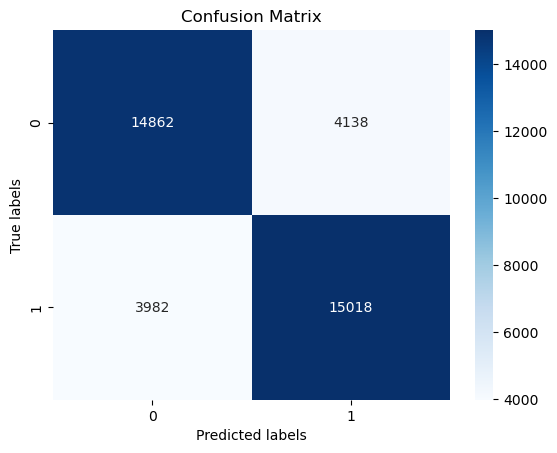

In [76]:
# confusion matrix heatmap with seaborn
cm = confusion_matrix(true_labels, predicted_labels)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")


In [89]:
# precision: out of all the predicted positive classes, how many were actually positive
precision = np.sum(cm[1, 1]) / (np.sum(cm[1, 1]) + np.sum(cm[0, 1]))
print("\nPrecision: {:.2f}".format(precision))

# recall: out of all the actual positive classes, how many were predicted positive
recall = np.sum(cm[1, 1]) / (np.sum(cm[1, 1]) + np.sum(cm[1, 0]))
print("Recall: {:.2f}".format(recall))


Precision: 0.78
Recall: 0.79


### Further considerations

One of our objectives was to create word embeddings specific to sentiment analysis. Arguably, we can use the word embeddings learned in this process for sentimen analysis on similar datasets. Let's see a couple of embeddings examples to see if we can extract any insights from them.

In [92]:
# add embeddings to vocab
embeddings = model.embedding.weight.detach().cpu().numpy()
word_to_embedding = {word: embeddings[i] for word, i in vocab.get_stoi().items()}


In [113]:
def compare_embeddings(word1, word2):
    """
    Compare the embeddings of two words
    """
    print(
        f"Comparing {word1} and {word2}: {np.dot(word_to_embedding[word1], word_to_embedding[word2]):.2f}"
    )


compare_embeddings("fantastic", "terrible")
compare_embeddings("fantastic", "phenomenal")
compare_embeddings("fantastic", "great")
compare_embeddings("fantastic", "bad")
compare_embeddings("terrible", "bad")
compare_embeddings("fantastic", "house")


Comparing fantastic and terrible: -31.67
Comparing fantastic and phenomenal: 19.67
Comparing fantastic and great: 8.23
Comparing fantastic and bad: -11.64
Comparing terrible and bad: 13.10
Comparing fantastic and house: 1.76


From the above results we can gather some intuition into some of the relationships that were learned: We would expect that words that convey similar sentiment would have similar embeddings (and therefore a positive dot product). Words that convey sentiment in the same direction but with different intensity would be positive but with a lower dot product. Words that convey sentiment in the opposite direction would have a negative dot product. Finally, comparing a word with sentimental value to a word with no sentimental value should result in a dot product close to zero.